In [1]:
###########import packages##########
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import xgboost as xgb
import lightgbm
import catboost
from sklearn.model_selection import GridSearchCV
from xgboost import plot_importance
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn import ensemble
from sklearn.tree import ExtraTreeRegressor
from sklearn import svm
from sklearn import neighbors
from sklearn import tree
import joblib
%matplotlib inline
###########wrapping root mean square error for later calls##########
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())
###########loading data##########
fdata=pd.read_csv('finaldatabase.csv',encoding="utf-8")
raw_data=fdata.loc[:,[                     
    'xN2a_in0',#0
    'RH_CC',#1
    'dela_CH (mm)',#2
    'dela_M (um)',#3
    'dela_GDL (um)',#4
    'p_A (atm)',#5
    'T_cc (K)',#6
    'E cell (V)',#7
    'current',#8
    'fyN2',#9
                        ]]
###########train test splitting##########
standardized_data = (raw_data-np.mean(raw_data,axis=0))/np.std(raw_data,axis=0)
raw_input=raw_data.iloc[:,0:8]
raw_output=raw_data.iloc[:,8]
###########fix random seed for reproducability##########
seed=1
X_train, X_test, y_train, y_test = train_test_split(raw_input, raw_output, test_size=.15,random_state=seed)
y_test_values=y_test.values.astype(np.float32)

########################################################
########################################################
#############Machine Learning Algorithms################
########################################################
########################################################
def gridsearch(model,param,algorithm_name):
    print('start')
    grid = GridSearchCV(model,param_grid=param,cv=5)
    grid.fit(X_train,y_train)
    print('Best Regressor:',grid.best_params_,'Best Score:', grid.best_score_)
    best_model=grid.best_estimator_
    result = best_model.predict(X_test)
    x_prediction=result
    y_real=y_test_values
    x_prediction_series=pd.Series(x_prediction)
    y_real_series=pd.Series(y_real)
    ###########evaluating the regression quality##########
    corr_ann = round(x_prediction_series.corr(y_real_series), 5)
    rmse_val= rmse(x_prediction,y_real)
    print(rmse_val)
    print(corr_ann)
    ###########generating a figure##########
    x_y_x=np.arange(0,2.6,0.1)
    x_y_y=np.arange(0,2.6,0.1)
    fig = plt.figure()
    ax = fig.add_subplot(111)
    ax.scatter(x_prediction,y_real,edgecolor='black',s=10,label=algorithm_name)
    ax.plot(x_y_x,x_y_y)
    plt.legend()
    plt.xlabel(u"predict current A/cm^2")
    plt.ylabel(u"real predict current A/cm^2")
    plt.savefig('%s CurrentRegression.jpg' %algorithm_name)
    plt.show()
    name_list=list(X_test)
    plt.bar(range(len(best_model.feature_importances_)), best_model.feature_importances_,edgecolor='black',tick_label=name_list)
    plt.xticks(rotation=90)
    plt.savefig('%s FeatureImportance.jpg' %algorithm_name)
    plt.show()
    print(best_model.feature_importances_)
    
    return best_model




start
Best Regressor: {'learning_rate': 0.2, 'max_depth': 9, 'reg_alpha': 0, 'reg_lambda': 0, 'subsample': 0.9} Best Score: 0.9998249081745664
0.0059633697
0.99994


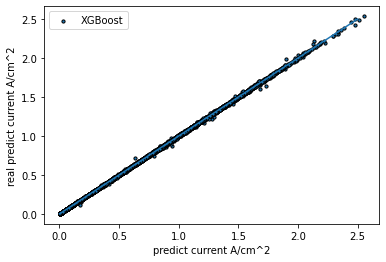

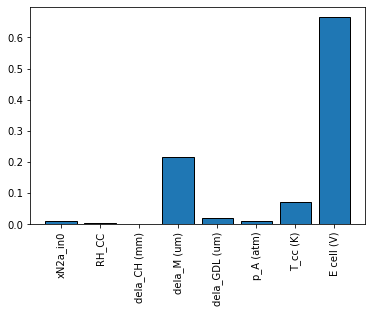

[0.00995405 0.00314745 0.00175955 0.21676786 0.01925483 0.01157039
 0.07296789 0.66457796]


['xgb_model']

In [2]:
###########XGBoost gridsearch CV for best hyperparameter##########
model_XGBRegressor = xgb.XGBRegressor(random_state=seed)
###########defining the parameters dictionary##########
param_xgb = {
    'learning_rate':[0.01,0.02,0.05,0.1,0.2,1],
    'subsample':[0.5,0.6,0.7,0.8,0.9,1],
    'reg_lambda':[0.1,0.01,0],
    'reg_alpha':[0.1,0.01,0],
    'max_depth':[3,5,7,9,11]
}
xgb_model=gridsearch(model_XGBRegressor,param_xgb,'XGBoost')
joblib.dump(xgb_model,'xgb_model')

start
Best Regressor: {'iterations': 400} Best Score: 0.9997350720859741
0.008653653717981404
0.99986


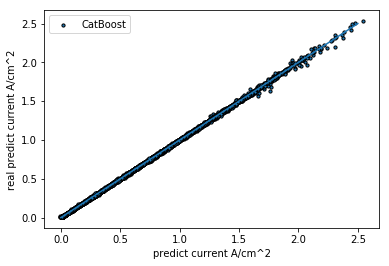

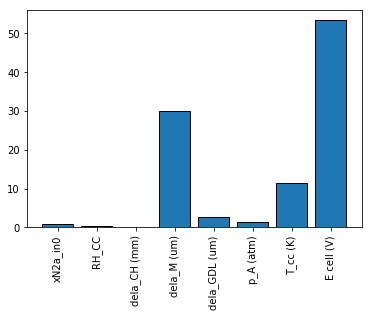

[ 0.82917392  0.40153083  0.10694777 29.87953728  2.65776576  1.45566901
 11.42661193 53.2427635 ]


['cat_model']

In [3]:
###########CatBoost gridsearch CV for best hyperparameter##########
model_CatboostRegressor=catboost.CatBoostRegressor(random_state=1,verbose=0)
param_cat = {'iterations':[50,100,200,400]
}
cat_model=gridsearch(model_CatboostRegressor,param_cat,'CatBoost')
joblib.dump(cat_model,'cat_model')

start
Best Regressor: {'learning_rate': 0.2, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.5} Best Score: 0.9992579401267815
0.013332966993821211
0.99968


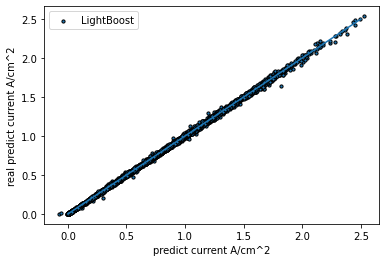

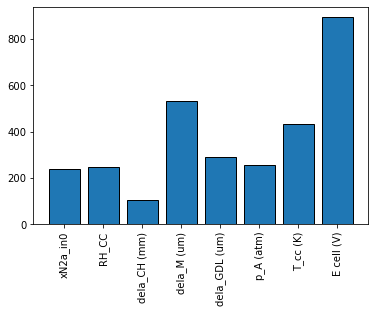

[238 249 106 532 290 257 435 893]


['lgb_model']

In [2]:

###########LGBM gridsearch CV for best hyperparameter##########
model_lgbmRegressor = lightgbm.LGBMRegressor(random_state=seed)
###########defining the parameters dictionary##########
param_lgbm = {
            'learning_rate':[0.01,0.02,0.05,0.1,0.2,1],
    'subsample':[0.5,0.6,0.7,0.8,0.9,1],
    'reg_lambda':[0.1,0.01,0],
    'reg_alpha':[0.1,0.01,0]
}
lgb_model=gridsearch(model_lgbmRegressor,param_lgbm,'LightBoost')
joblib.dump(lgb_model,'lgb_model')

start
Best Regressor: {'loss': 'ls', 'max_features': 'auto'} Best Score: 0.9932597988866918
0.04367934787197502
0.99659


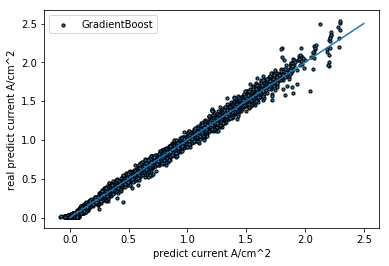

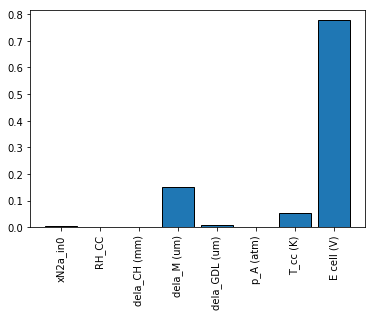

[3.69749254e-03 5.12583067e-04 7.28515196e-05 1.51876787e-01
 9.15884117e-03 2.63416828e-03 5.52623766e-02 7.76784900e-01]


['gdb_model']

In [5]:

###########GradientBoost gridsearch CV for best hyperparameter##########
model_GradientBoostingRegressor = ensemble.GradientBoostingRegressor(random_state=seed)
###########defining the parameters dictionary##########
param_GB = {
         'max_features':['auto','sqrt','log2'],
         'loss':['ls', 'lad', 'huber', 'quantile']
}
gdb_model=gridsearch(model_GradientBoostingRegressor,param_GB,'GradientBoost')
joblib.dump(gdb_model,'gdb_model')

start
Best Regressor: {'max_features': 'auto'} Best Score: 0.9992915256405442
0.013509884691481695
0.99967


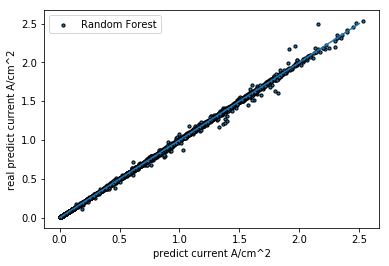

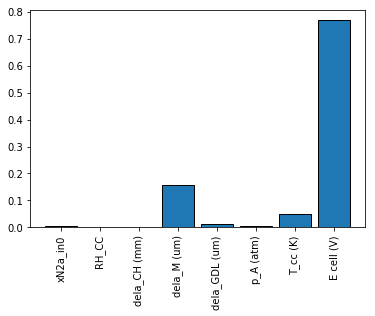

[4.26546091e-03 2.51963821e-03 4.85854977e-04 1.55999121e-01
 1.16880713e-02 6.56796693e-03 5.07614661e-02 7.67712420e-01]


['rf_model']

In [6]:
###########RandomForest gridsearch CV for best hyperparameter##########
model_RandomForestRegressor = ensemble.RandomForestRegressor(random_state=seed)
###########defining the parameters dictionary##########
param_RF = {
    'max_features':['auto','sqrt','log2']
}
rf_model=gridsearch(model_RandomForestRegressor,param_RF,'Random Forest')

joblib.dump(rf_model,'rf_model')

start
Best Regressor: {'criterion': 'mse', 'splitter': 'best'} Best Score: 0.9987662675439095
0.01668647897474396
0.9995


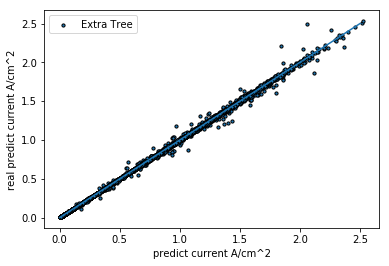

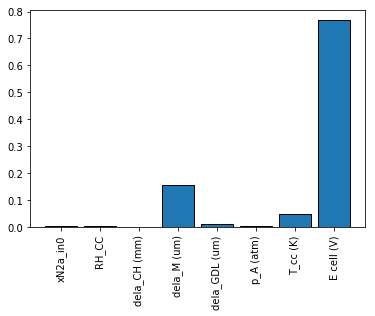

[4.05456013e-03 3.52196391e-03 4.41597136e-04 1.56669112e-01
 1.14225766e-02 6.96782724e-03 4.96705751e-02 7.67251788e-01]


['et_model']

In [7]:

###########Extra Tree gridsearch CV for best hyperparameter##########
model_ExtraTreeRegressor = ExtraTreeRegressor(random_state=seed)
param_ET = {
       'criterion' : ["mse", "friedman_mse", "mae"],
       'splitter' : [ "best",'random']
}
et_model=gridsearch(model_ExtraTreeRegressor,param_ET,'Extra Tree')
joblib.dump(et_model,'et_model')

start
Best Regressor: {'criterion': 'mse', 'max_features': 'auto', 'splitter': 'best'} Best Score: 0.9987662675439095
0.01668647897474396
0.9995


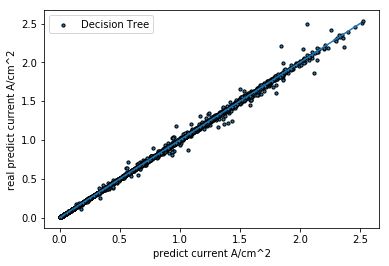

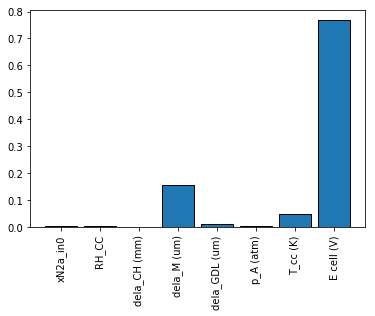

[4.05456013e-03 3.52196391e-03 4.41597136e-04 1.56669112e-01
 1.14225766e-02 6.96782724e-03 4.96705751e-02 7.67251788e-01]


['dt_model']

In [8]:
###########Decision Tree gridsearch CV for best hyperparameter##########
model_DecisionTreeRegressor = tree.DecisionTreeRegressor(random_state=seed)
param_DT = {
         'criterion':['mse','mae','friedman_mse'],
         'splitter':['random','best'],
         'max_features':["auto", "sqrt", "log2"]
}
dt_model=gridsearch(model_DecisionTreeRegressor,param_DT,'Decision Tree')
joblib.dump(dt_model,'dt_model')

start
Best Regressor: {'learning_rate': 1, 'loss': 'exponential'} Best Score: 0.9329426121606303
0.1307025012638749
0.97602


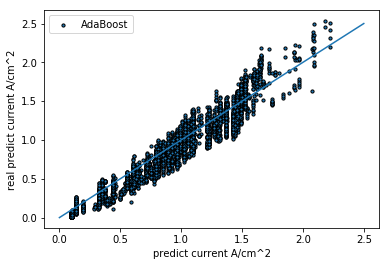

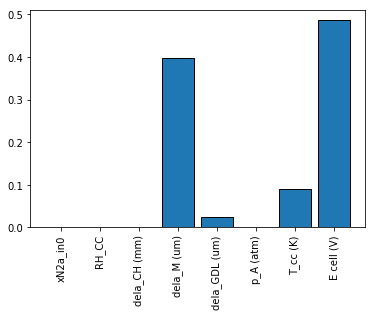

[0.         0.00130073 0.         0.39758156 0.02512944 0.
 0.08972824 0.48626002]


['ada_model']

In [9]:
###########AdaBoost gridsearch CV for best hyperparameter##########
model_AdaBoostRegressor = ensemble.AdaBoostRegressor(random_state=seed)
param_Ada = {
    'learning_rate':[0.01,0.02,0.05,0.1,0.2,1],
    'loss':['linear', 'square', 'exponential']
}
ada_model=gridsearch(model_AdaBoostRegressor,param_Ada,'AdaBoost')
joblib.dump(ada_model,'ada_model')